Reading doctors from gs://hospital_datalake/topics/postgres-source.public.doctors/*.json
Reading patients from gs://hospital_datalake/topics/postgres-source.public.patients/*.json


25/04/14 21:27:26 WARN CacheManager: Asked to cache already cached data.
25/04/14 21:27:29 WARN CacheManager: Asked to cache already cached data.        


Reading medicines from gs://hospital_datalake/topics/postgres-source.public.medicines/*.json


25/04/14 21:27:30 WARN CacheManager: Asked to cache already cached data.


Reading visits from gs://hospital_datalake/topics/postgres-source.public.visits/*.json


Reading billing_payments from gs://hospital_datalake/topics/postgres-source.public.billing_payments/*.json


25/04/14 21:27:31 WARN CacheManager: Asked to cache already cached data.
25/04/14 21:27:32 WARN CacheManager: Asked to cache already cached data.


Reading prescriptions from gs://hospital_datalake/topics/postgres-source.public.prescriptions/*.json


25/04/14 21:27:33 WARN CacheManager: Asked to cache already cached data.


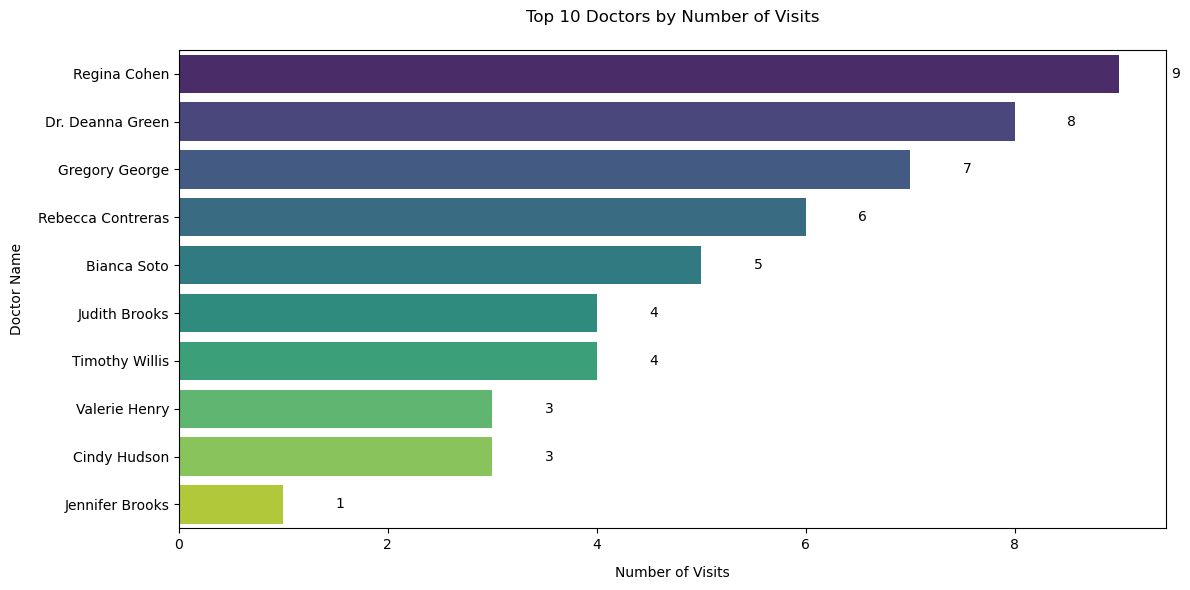

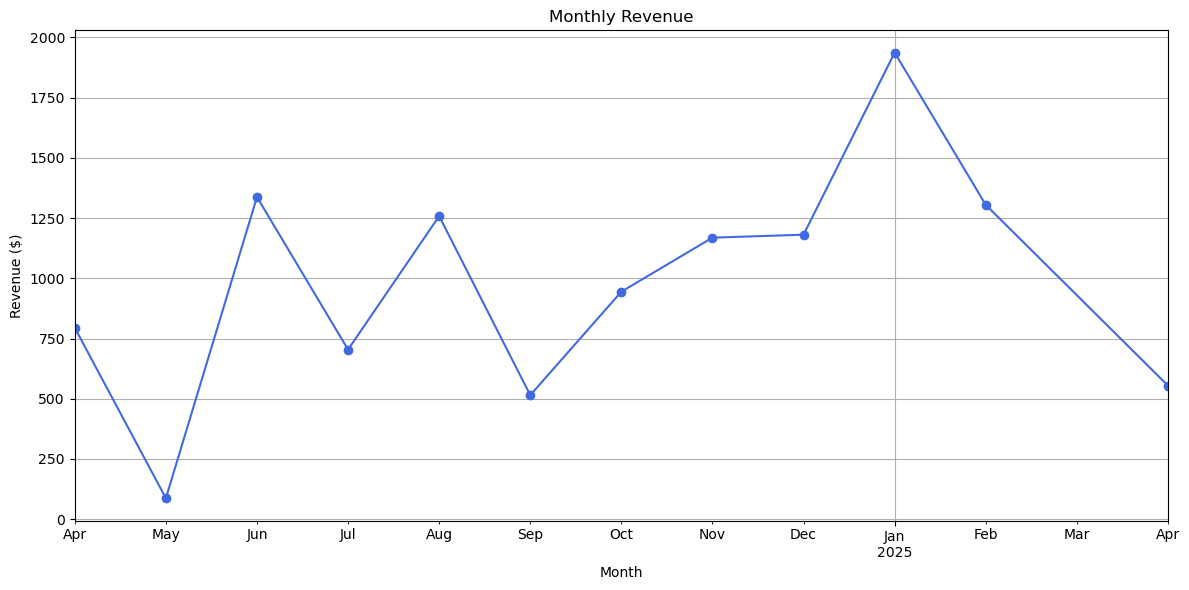

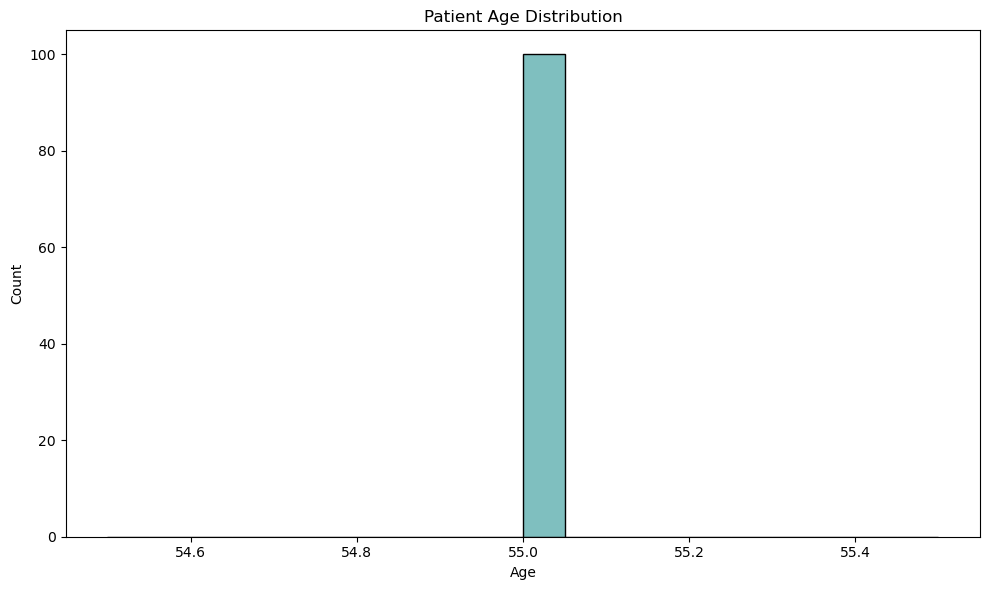

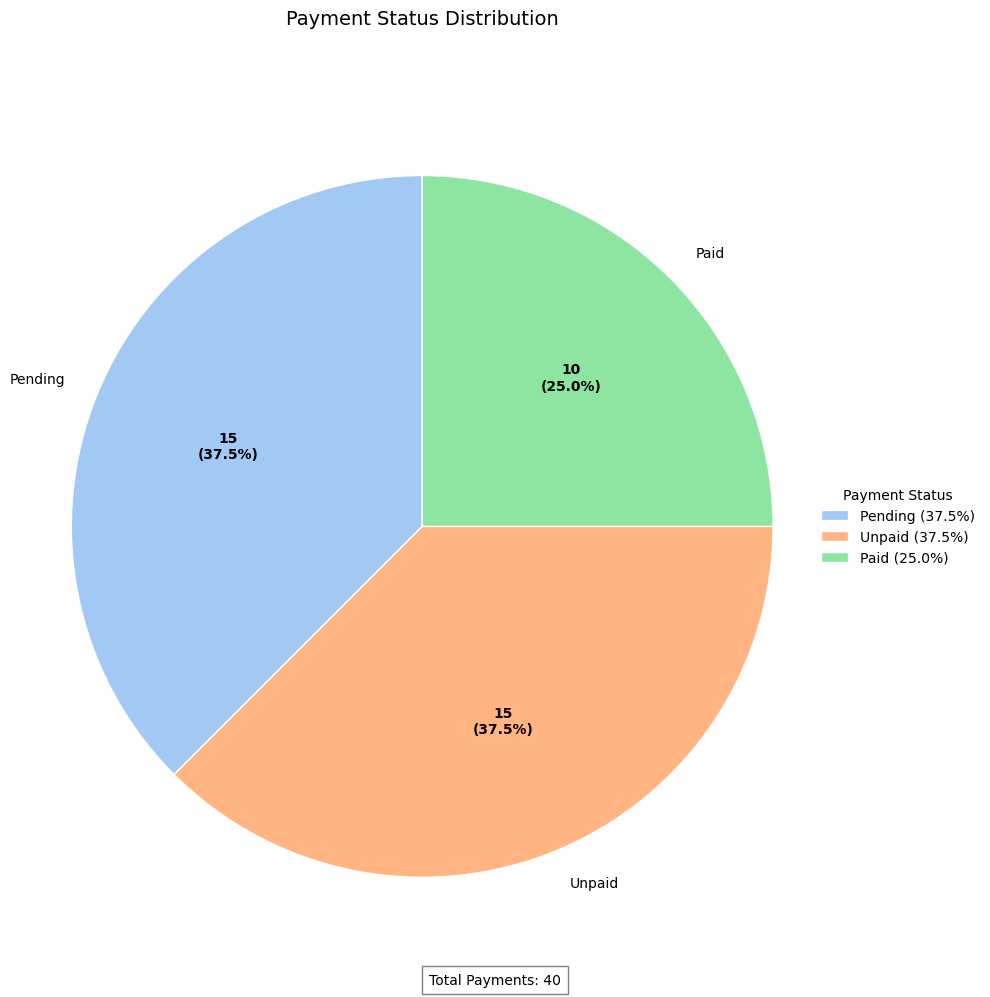

Columns in merged prescriptions data: ['doctor_id', 'dosage', 'duration', 'medicine_id', 'patient_id', 'prescription_id', 'category', 'manufacturer', 'medicine_name', 'price']


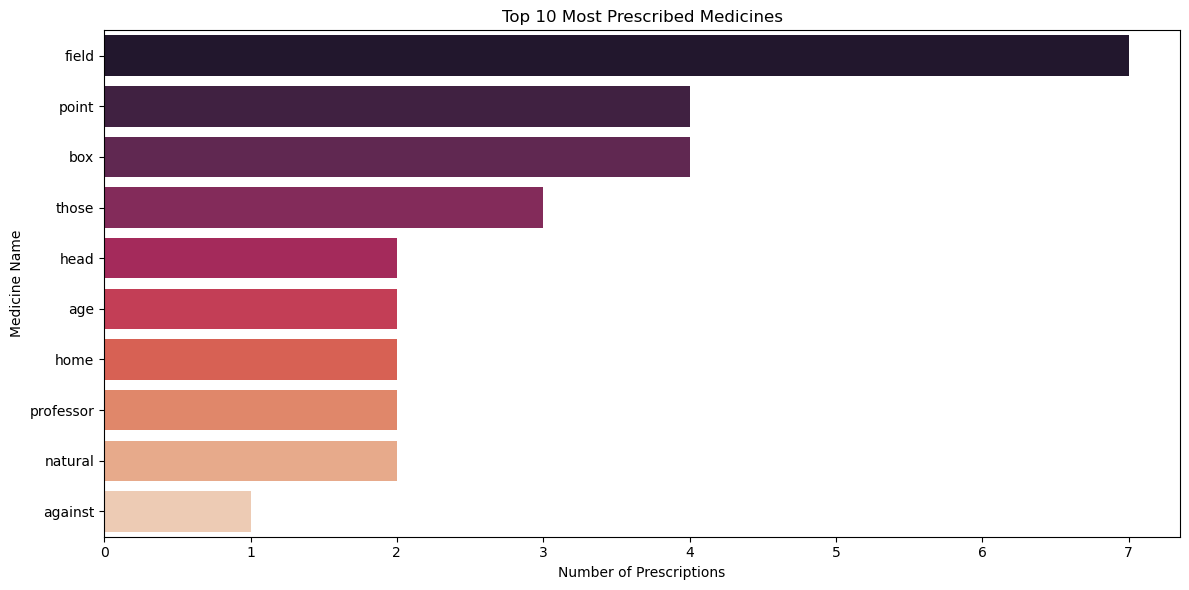

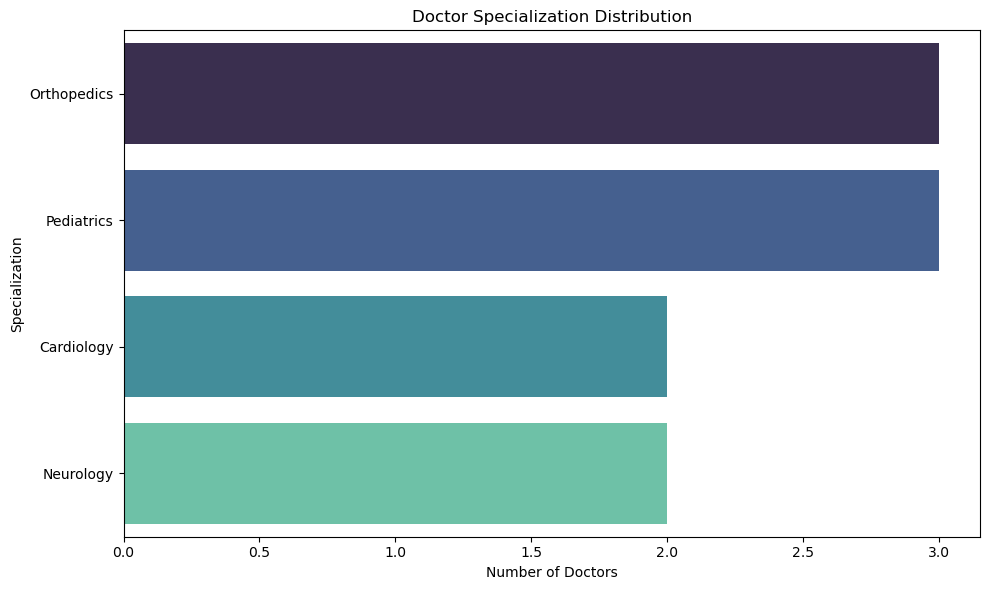

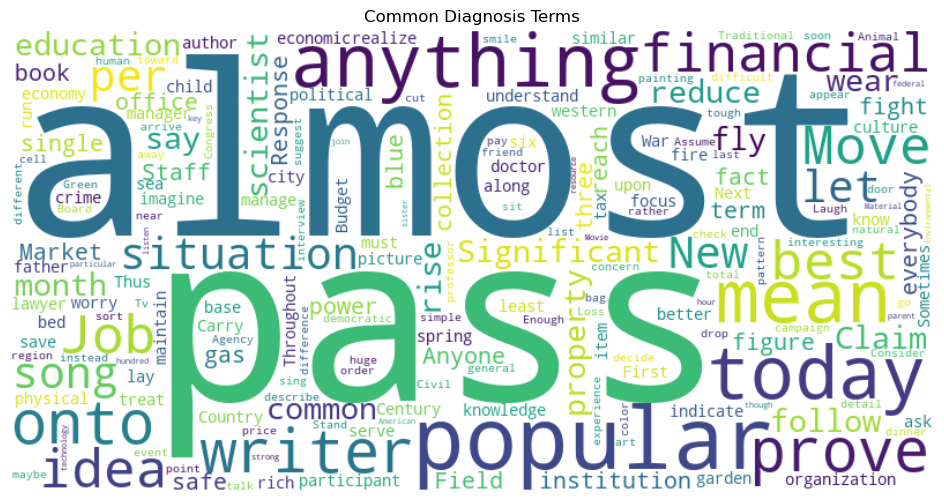

In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import os
from pyspark.sql.functions import col, date_add, lit

gcs_credential_path = os.path.expanduser("~/gcs.json") 

# Initialize Spark session with GCS configuration
spark = SparkSession.builder \
    .appName("GCSDataAnalysis") \
    .config("spark.jars", "/usr/lib/jars/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", f"{gcs_credential_path}") \
    .getOrCreate()

# GCS bucket configuration
GCS_BUCKET = "hospital_datalake"
TABLES = ["doctors", "patients", "medicines", "visits", "billing_payments", "prescriptions"]

# Read all tables from GCS with possible value column handling
dfs = {}
for table in TABLES:
    gcs_path = f"gs://{GCS_BUCKET}/topics/postgres-source.public.{table}/*.json"
    print(f"Reading {table} from {gcs_path}")
    
    # Read data with multiLine option
    temp_df = spark.read.option("multiLine", True).json(gcs_path)
    
    # If there is value column in JSON file 
    if "value" in temp_df.columns:
        # Extarct data from value column
        temp_df = temp_df.select("value.*")
    
    dfs[table] = temp_df.cache()
    
# Convert relevant Spark DataFrames to Pandas for visualization
doctors_pd = dfs["doctors"].toPandas()
patients_pd = dfs["patients"].toPandas()
visits_pd = dfs["visits"].toPandas()
billing_pd = dfs["billing_payments"].toPandas()
prescriptions_pd = dfs["prescriptions"].toPandas()
medicines_pd = dfs["medicines"].toPandas()

# Data preprocessing
# Convert date columns to datetime
visits_pd['visit_date'] = pd.to_datetime(visits_pd['visit_date'])
billing_pd['billing_date'] = pd.to_datetime(billing_pd['billing_date'])

# Merge data for analysis
visits_with_doctors = visits_pd.merge(
    doctors_pd, 
    left_on='doctor_id', 
    right_on='doctor_id', 
    how='left'
)

billing_with_visits = billing_pd.merge(
    visits_pd, 
    left_on='visit_id', 
    right_on='visit_id', 
    how='left'
)


# Visualization 1: Doctor Performance (Number of Visits per Doctor)
plt.figure(figsize=(12, 6))
doctor_visits = visits_with_doctors['name'].value_counts().head(10)
ax = sns.barplot(
    x=doctor_visits.values, 
    y=doctor_visits.index, 
    hue=doctor_visits.index,
    palette='viridis',
    legend=False
)
plt.title('Top 10 Doctors by Number of Visits', pad=20)
plt.xlabel('Number of Visits', labelpad=10)
plt.ylabel('Doctor Name', labelpad=10)

# Add value labels
for i, v in enumerate(doctor_visits.values):
    ax.text(v + 0.5, i, str(v), color='black', va='center')

plt.tight_layout()
plt.savefig('../../images/pyspark_doctor_performance.png')
plt.show()


# Visualization 2: Monthly Revenue (using billing_date instead of payment_date)
plt.figure(figsize=(12, 6))
billing_with_visits['month'] = billing_with_visits['billing_date'].dt.to_period('M')
monthly_revenue = billing_with_visits.groupby('month')['total_amount'].sum()
monthly_revenue.plot(kind='line', marker='o', color='royalblue')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.tight_layout()
plt.savefig('../../images/pyspark_monthly_revenue.png')
plt.show()


# Visualization 3: Patient Age Distribution
plt.figure(figsize=(10, 6))
patients_pd['age'] = (pd.to_datetime('today') - pd.to_datetime(patients_pd['date_of_birth'])).dt.days // 365
sns.histplot(patients_pd['age'], bins=20, kde=True, color='teal')
plt.title('Patient Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('../../images/pyspark_patient_age_distribution.png')
plt.show()


# Visualization 4: Payment Status Distribution
plt.figure(figsize=(10, 10))

# Get value counts and calculate percentages
payment_status = billing_pd['payment_status'].value_counts()
percentages = (payment_status / payment_status.sum()) * 100

# Create custom autopct function to show both count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val:,}\n({pct:.1f}%)' if pct > 5 else ''
    return my_autopct

# Create pie chart with improvements
wedges, texts, autotexts = plt.pie(
    payment_status,
    labels=payment_status.index,
    autopct=make_autopct(payment_status),
    startangle=90,
    colors=sns.color_palette('pastel'),
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 10}
)

plt.axis('equal')
plt.title('Payment Status Distribution\n', fontsize=14, pad=20)

# Add legend with percentages outside the pie
plt.legend(
    wedges,
    [f'{label} ({perc:.1f}%)' for label, perc in zip(payment_status.index, percentages)],
    title="Payment Status",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    frameon=False
)

# Make the percentage labels inside the pie more readable
plt.setp(autotexts, size=10, weight="bold", color='black')

# Add explanatory text if needed
plt.figtext(0.5, 0.01, 
           f"Total Payments: {payment_status.sum():,}",
           ha="center", 
           fontsize=10,
           bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.tight_layout()
plt.savefig('../../images/pyspark_payment_status.png', bbox_inches='tight', dpi=300)
plt.show()


# Visualization 5: Prescription Medicine Analysis
prescriptions_with_meds = prescriptions_pd.merge(
    medicines_pd.rename(columns={'name': 'medicine_name'}),
    left_on='medicine_id', 
    right_on='medicine_id', 
    how='left'
)

# Check available columns to debug
print("Columns in merged prescriptions data:", prescriptions_with_meds.columns.tolist())

# Find the medicine name column (it might be 'medicine_name' now)
medicine_name_col = 'medicine_name' if 'medicine_name' in prescriptions_with_meds.columns else 'name'

top_meds = prescriptions_with_meds[medicine_name_col].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_meds.values, 
            y=top_meds.index, 
            hue=top_meds.index,  # Added hue parameter
            palette='rocket',
            legend=False)  # Disabled legend
plt.title('Top 10 Most Prescribed Medicines')
plt.xlabel('Number of Prescriptions')
plt.ylabel('Medicine Name')
plt.tight_layout()
plt.savefig('../../images/pyspark_top_medicines.png')
plt.show()


# Visualization 6: Doctor Specialization Distribution
plt.figure(figsize=(10, 6))
specialization_counts = doctors_pd['specialization'].value_counts()
sns.barplot(x=specialization_counts.values, 
            y=specialization_counts.index, 
            hue=specialization_counts.index,  # Added hue parameter
            palette='mako',
            legend=False)  # Disabled legend

plt.title('Doctor Specialization Distribution')
plt.xlabel('Number of Doctors')
plt.ylabel('Specialization')
plt.tight_layout()
plt.savefig('../../images/pyspark_doctor_specializations.png')
plt.show()


# Visualization 7: Visit Diagnosis Word Cloud (optional)
# Generate a word cloud of common diagnoses

# pip install wordcloud
from wordcloud import WordCloud

diagnosis_text = ' '.join(visits_pd['diagnosis'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(diagnosis_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Diagnosis Terms')
plt.savefig('../../images/pyspark_diagnosis_wordcloud.png')
plt.show()


# Close Spark session
spark.stop()